In [1]:
#  bibliothèques
import os              # Pour gérer les chemins de fichiers
import pandas as pd    # Pour manipuler les fichiers CSV et les données tabulaires
import matplotlib.pyplot as plt  # Pour visualiser les données et les images
import cv2             # Pour charger et traiter les images


In [2]:
#  Définition des chemins vers les données

data_path = '../data/raw'  # Dossier contenant les datasets
labels_path = os.path.join(data_path, 'cleaned_data.csv')  # CSV nettoyé
images_dir = os.path.join(data_path, 'images')             # Dossier des images


In [3]:
# Chargement des labels
df = pd.read_csv(labels_path)

# Nettoyage des noms de colonnes pour supprimer les espaces invisibles
df.columns = df.columns.str.strip()

# Colonnes importantes pour l'analyse
df = df[['Image Index', 'Finding Labels', 'Patient Age', 'Patient Gender']]

# Aperçu des 20 premières lignes
print("Aperçu des 20 premières lignes du dataset :\n")
print(df.head(20))
print("\nDimensions du dataframe :", df.shape)

Aperçu des 20 premières lignes du dataset :

         Image Index          Finding Labels  Patient Age Patient Gender
0   00000001_000.png            Cardiomegaly           58              M
1   00000001_001.png  Cardiomegaly|Emphysema           58              M
2   00000001_002.png   Cardiomegaly|Effusion           58              M
3   00000002_000.png              No Finding           81              M
4   00000003_000.png                  Hernia           81              F
5   00000003_001.png                  Hernia           74              F
6   00000003_002.png                  Hernia           75              F
7   00000003_003.png     Hernia|Infiltration           76              F
8   00000003_004.png                  Hernia           77              F
9   00000003_005.png                  Hernia           78              F
10  00000003_006.png                  Hernia           79              F
11  00000003_007.png                  Hernia           80              F
12  00

In [4]:

# Liste des pathologies
pathologies = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 
               'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 
               'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']

# Transformation en colonnes binaires
for p in pathologies:
    df[p] = df['Finding Labels'].apply(lambda x: 1 if p in x else 0)

# Vérification
print("\nComptage des pathologies :")
print(df[pathologies].sum())



Comptage des pathologies :
Atelectasis           11559
Cardiomegaly           2776
Effusion              13317
Infiltration          19894
Mass                   5782
Nodule                 6331
Pneumonia              1431
Pneumothorax           5302
Consolidation          4667
Edema                  2303
Emphysema              2516
Fibrosis               1686
Pleural_Thickening     3385
Hernia                  227
dtype: int64


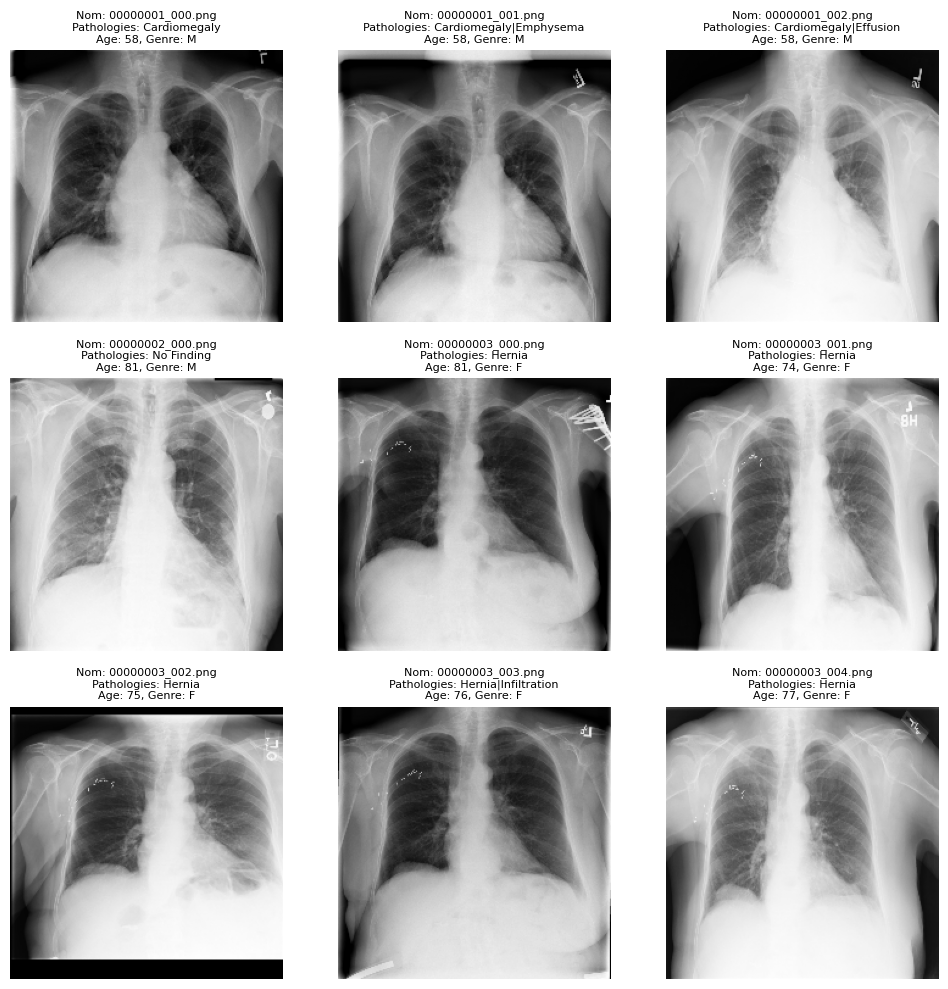

In [5]:

#  Exploration  des images avec informations supplémentaires

# Fonction pour charger une image en niveaux de gris et la redimensionner
def load_image(img_name, size=(224,224)):
    path = os.path.join(images_dir, img_name)  # Construction du chemin complet
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Chargement de l'image en gris
    if img is None:  # Vérification que l'image existe
        print(f" Image non trouvée : {path}")
        return None
    img = cv2.resize(img, size)  # Redimensionnement à la taille souhaitée
    img = img / 255.0  # Normalisation des pixels (0-1)
    return img

# Sélection de 10 images d'exemple depuis le dataset
sample_images = df['Image Index'].head(10).tolist()

# Création d'une figure pour afficher les images (3 lignes × 3 colonnes)
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Boucle pour afficher chaque image avec ses informations
for ax, img_name in zip(axes.flatten(), sample_images):
    img = load_image(img_name)  # Chargement de l'image
    if img is not None:
        # Récupération des informations du patient depuis le dataframe
        row = df[df['Image Index'] == img_name].iloc[0]
        # Création du titre avec nom, pathologies, âge et genre
        titre = f"Nom: {row['Image Index']}\nPathologies: {row['Finding Labels']}\nAge: {row['Patient Age']}, Genre: {row['Patient Gender']}"
        ax.set_title(titre, fontsize=8)  # Ajout du titre à l'image
        ax.imshow(img, cmap='gray')  # Affichage de l'image
    else:
        ax.set_title("Erreur de chargement", fontsize=8)  # Message si image non trouvée
    ax.axis('off')  # Masque les axes pour plus de clarté

plt.tight_layout()  # Ajuste les espaces entre les images
plt.show()  # Affiche la figure


In [6]:
# Statistiques des patients
print("\nÂge moyen des patients :", df['Patient Age'].mean())
print("\nRépartition par genre :")
print(df['Patient Gender'].value_counts())



Âge moyen des patients : 46.90146271851587

Répartition par genre :
Patient Gender
M    63340
F    48780
Name: count, dtype: int64
